### 1/ Brief description of the problem and data

This project is about changing random images into a Monet style painting. In order to achieve this, a Generative Adverserial Network (GAN) must be trained to:
* learn what the Monet style is
* apply it to other photos

The project comes with files in two format:
* tfrec - a tensorflow  record file format
* jpg - a well-known image format
The files are **256*256** pixels with **RGD** channels.

The model best suited to this type of task is called a CycleGAN, which cycles through the generation and discrimination of of the generated images.

Note: having failed to create the CycleGAN from scratch, I had to rely heavily on the recommended tutorial on the Kaggle project page: https://www.kaggle.com/code/amyjang/monet-cyclegan-tutorial

### 2/ Exploratory Data Analysis (EDA) — Inspect, Visualize and Clean the Data

##### 2.1/ Import libraries and some initialization

Let's start by importing our standard libraries.

In [1]:
# usual imports
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import shutil
import tensorflow as tf
import tensorflow_addons as tfa

from os import listdir
from os.path import isfile, join
from PIL import Image
from tensorflow import keras
from tensorflow.keras import layers

C:\Users\edoua\anaconda3\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


Then, we setup some variable for repeatability.

In [2]:
# some initial parameters
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)
autotune = tf.data.AUTOTUNE

##### 2.2/ Loading the jpg

We will first load the jpg files.

In [3]:
# directories
monet_dir = 'monet_jpg/'
photo_dir = 'photo_jpg/'

In [4]:
# retrieve filenames
monet_filenames = [join(monet_dir, f) for f in listdir(monet_dir) if isfile(join(monet_dir, f))]
photo_filenames = [join(photo_dir, f) for f in listdir(photo_dir) if isfile(join(photo_dir, f))]

In [5]:
# convert to np.arrays
monet_files = [np.array(Image.open(f)) for f in monet_filenames]
photo_files = [np.array(Image.open(f)) for f in photo_filenames]

In [6]:
# some metrics
print("monet files: " + str(len(monet_files)))
print("photo files: " + str(len(photo_files)))
print("image shape: " + str(monet_files[1].shape))

monet files: 300
photo files: 7038
image shape: (256, 256, 3)


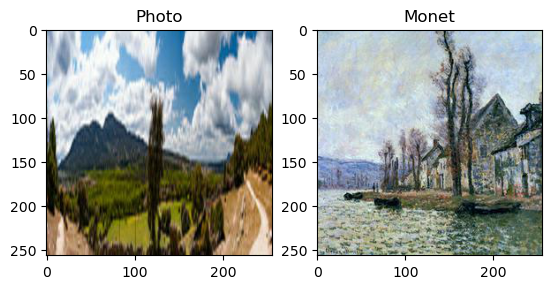

In [7]:
# let's print some examples
plt.subplot(121)
plt.title('Photo')
plt.imshow(mpimg.imread(photo_filenames[42]))

plt.subplot(122)
plt.title('Monet')
plt.imshow(mpimg.imread(monet_filenames[42]))

##### Loading the tfrec

Then, we will load the Tfrec files.

In [8]:
# retrieving tfrec
monet_tfrec = tf.io.gfile.glob(str('monet_tfrec/*.tfrec'))
photo_tfrec = tf.io.gfile.glob(str('photo_tfrec/*.tfrec'))

In [9]:
# show number of files
print('Monet TFRecord Files:', len(monet_tfrec))
print('Photo TFRecord Files:', len(photo_tfrec))

Monet TFRecord Files: 5
Photo TFRecord Files: 20


We need a function to decode the tfrec file format.

In [10]:
# image size
IMAGE_SIZE = [256, 256]

# allows to decode an image
def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    return image

# read teh tfrec file format
def read_tfrecord(example):
    tfrecord_format = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    return image

Then, we will create a function to load the datasets.

In [11]:
# load all tfrec
def load_dataset(filenames, labeled=True, ordered=False):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_tfrecord)
    return dataset

Let's load our tfrec files for both Monet and Photo

In [12]:
# load tfrec datasets
monet_ds = load_dataset(monet_tfrec, labeled=True).batch(1)
photo_ds = load_dataset(photo_tfrec, labeled=True).batch(1)

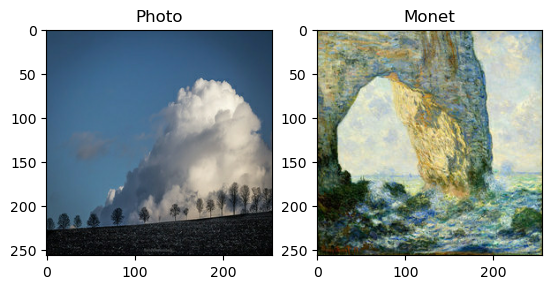

In [13]:
# retrieve an example of each and print them
example_monet = next(iter(monet_ds))
example_photo = next(iter(photo_ds))

plt.subplot(121)
plt.title('Photo')
plt.imshow(example_photo[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Monet')
plt.imshow(example_monet[0] * 0.5 + 0.5)

### 3/ Model Architecture

The architecture of a CycleGAN loop through a generator and a discriminator. Each are conventional convolutional deep learning models using layers to reduce and augment the image size.

##### 3.1/ Build the generator

Let's start by creating the layers to reduce and augment the image size.

In [14]:
# number of channel
OUTPUT_CHANNELS = 3

# function to reduce the image size
def downsample(filters, size, apply_instancenorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = keras.Sequential()
    result.add(layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

    if apply_instancenorm:
        result.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))

    result.add(layers.LeakyReLU())

    return result

In [15]:
# function to augment the image size
def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = keras.Sequential()
    result.add(layers.Conv2DTranspose(filters, size, strides=2,
                                      padding='same',
                                      kernel_initializer=initializer,
                                      use_bias=False))

    result.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))

    if apply_dropout:
        result.add(layers.Dropout(0.5))

    result.add(layers.ReLU())

    return result

Let's use those layers to assemble the generator.

In [16]:
# function to generate new image
def Generator():
    inputs = layers.Input(shape=[256,256,3])

    # bs = batch size
    down_stack = [
        downsample(64, 4, apply_instancenorm=False), # (bs, 128, 128, 64)
        downsample(128, 4), # (bs, 64, 64, 128)
        downsample(256, 4), # (bs, 32, 32, 256)
        downsample(512, 4), # (bs, 16, 16, 512)
        downsample(512, 4), # (bs, 8, 8, 512)
        downsample(512, 4), # (bs, 4, 4, 512)
        downsample(512, 4), # (bs, 2, 2, 512)
        downsample(512, 4), # (bs, 1, 1, 512)
    ]

    up_stack = [
        upsample(512, 4, apply_dropout=True), # (bs, 2, 2, 1024)
        upsample(512, 4, apply_dropout=True), # (bs, 4, 4, 1024)
        upsample(512, 4, apply_dropout=True), # (bs, 8, 8, 1024)
        upsample(512, 4), # (bs, 16, 16, 1024)
        upsample(256, 4), # (bs, 32, 32, 512)
        upsample(128, 4), # (bs, 64, 64, 256)
        upsample(64, 4), # (bs, 128, 128, 128)
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                  strides=2,
                                  padding='same',
                                  kernel_initializer=initializer,
                                  activation='tanh') # (bs, 256, 256, 3)

    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = layers.Concatenate()([x, skip])

    x = last(x)

    return keras.Model(inputs=inputs, outputs=x)

##### 3.2/ Build the discriminator

Now, we can create the discriminator.

In [17]:
# function to determine if an image is real or fake
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    inp = layers.Input(shape=[256, 256, 3], name='input_image')

    x = inp

    down1 = downsample(64, 4, False)(x) # (bs, 128, 128, 64)
    down2 = downsample(128, 4)(down1) # (bs, 64, 64, 128)
    down3 = downsample(256, 4)(down2) # (bs, 32, 32, 256)

    zero_pad1 = layers.ZeroPadding2D()(down3) # (bs, 34, 34, 256)
    conv = layers.Conv2D(512, 4, strides=1,
                         kernel_initializer=initializer,
                         use_bias=False)(zero_pad1) # (bs, 31, 31, 512)

    norm1 = tfa.layers.InstanceNormalization(gamma_initializer=gamma_init)(conv)

    leaky_relu = layers.LeakyReLU()(norm1)

    zero_pad2 = layers.ZeroPadding2D()(leaky_relu) # (bs, 33, 33, 512)

    last = layers.Conv2D(1, 4, strides=1,
                         kernel_initializer=initializer)(zero_pad2) # (bs, 30, 30, 1)

    return tf.keras.Model(inputs=inp, outputs=last)

We need two generators and two discriminators. Let's instance them.

In [18]:
# instance both generators and discriminators
monet_generator = Generator()
photo_generator = Generator()

monet_discriminator = Discriminator()
photo_discriminator = Discriminator()

##### 3.3/ Build the CycleGAN

Now that all the building blocks are made, we can assemble our CycleGAN.

In [19]:
# main class to link generators and discriminator into a trainable solution
class CycleGan(keras.Model):
    def __init__(
        self,
        monet_generator,
        photo_generator,
        monet_discriminator,
        photo_discriminator,
        lambda_cycle=10,
    ):
        super(CycleGan, self).__init__()
        self.m_gen = monet_generator
        self.p_gen = photo_generator
        self.m_disc = monet_discriminator
        self.p_disc = photo_discriminator
        self.lambda_cycle = lambda_cycle
        
    def compile(
        self,
        m_gen_optimizer,
        p_gen_optimizer,
        m_disc_optimizer,
        p_disc_optimizer,
        gen_loss_fn,
        disc_loss_fn,
        cycle_loss_fn,
        identity_loss_fn
    ):
        super(CycleGan, self).compile()
        self.m_gen_optimizer = m_gen_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn
        
    def train_step(self, batch_data):
        real_monet, real_photo = batch_data
        
        with tf.GradientTape(persistent=True) as tape:
            # photo to monet back to photo
            fake_monet = self.m_gen(real_photo, training=True)
            cycled_photo = self.p_gen(fake_monet, training=True)

            # monet to photo back to monet
            fake_photo = self.p_gen(real_monet, training=True)
            cycled_monet = self.m_gen(fake_photo, training=True)

            # generating itself
            same_monet = self.m_gen(real_monet, training=True)
            same_photo = self.p_gen(real_photo, training=True)

            # discriminator used to check, inputing real images
            disc_real_monet = self.m_disc(real_monet, training=True)
            disc_real_photo = self.p_disc(real_photo, training=True)

            # discriminator used to check, inputing fake images
            disc_fake_monet = self.m_disc(fake_monet, training=True)
            disc_fake_photo = self.p_disc(fake_photo, training=True)

            # evaluates generator loss
            monet_gen_loss = self.gen_loss_fn(disc_fake_monet)
            photo_gen_loss = self.gen_loss_fn(disc_fake_photo)

            # evaluates total cycle consistency loss
            total_cycle_loss = self.cycle_loss_fn(real_monet, cycled_monet, self.lambda_cycle) + self.cycle_loss_fn(real_photo, cycled_photo, self.lambda_cycle)

            # evaluates total generator loss
            total_monet_gen_loss = monet_gen_loss + total_cycle_loss + self.identity_loss_fn(real_monet, same_monet, self.lambda_cycle)
            total_photo_gen_loss = photo_gen_loss + total_cycle_loss + self.identity_loss_fn(real_photo, same_photo, self.lambda_cycle)

            # evaluates discriminator loss
            monet_disc_loss = self.disc_loss_fn(disc_real_monet, disc_fake_monet)
            photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo)

        # Calculate the gradients for generator and discriminator
        monet_generator_gradients = tape.gradient(total_monet_gen_loss, self.m_gen.trainable_variables)
        photo_generator_gradients = tape.gradient(total_photo_gen_loss, self.p_gen.trainable_variables)
        monet_discriminator_gradients = tape.gradient(monet_disc_loss, self.m_disc.trainable_variables)
        photo_discriminator_gradients = tape.gradient(photo_disc_loss, self.p_disc.trainable_variables)

        # Apply the gradients to the optimizer
        self.m_gen_optimizer.apply_gradients(zip(monet_generator_gradients, self.m_gen.trainable_variables))
        self.p_gen_optimizer.apply_gradients(zip(photo_generator_gradients, self.p_gen.trainable_variables))
        self.m_disc_optimizer.apply_gradients(zip(monet_discriminator_gradients, self.m_disc.trainable_variables))
        self.p_disc_optimizer.apply_gradients(zip(photo_discriminator_gradients, self.p_disc.trainable_variables))
        
        return {
            "monet_gen_loss": total_monet_gen_loss,
            "photo_gen_loss": total_photo_gen_loss,
            "monet_disc_loss": monet_disc_loss,
            "photo_disc_loss": photo_disc_loss
        }

##### 3.4/ Loss functions

In order to follow the progress during training, we need to calculate the losses for:
* the generator
* the discriminator
* the cycle consistency
* the identity

In [20]:
# loss function for the discriminator
def discriminator_loss(real, generated):
    real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(real), real)
    generated_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.zeros_like(generated), generated)
    total_disc_loss = real_loss + generated_loss

    return total_disc_loss * 0.5

In [21]:
# loss function for the generator
def generator_loss(generated):
    return tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(generated), generated)

In [22]:
# loss for the cycle consistency
def calc_cycle_loss(real_image, cycled_image, LAMBDA):
    loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))
    return LAMBDA * loss1

In [23]:
# loss for the identity
def identity_loss(real_image, same_image, LAMBDA):
    loss = tf.reduce_mean(tf.abs(real_image - same_image))
    return LAMBDA * 0.5 * loss

##### 3.5/ Train the CycleGAN

In order to build the CycleGAN, we need four optimizers. We will use Adam.

In [24]:
# instance all necessary optimizer
monet_generator_optimizer = tf.keras.optimizers.Adam(1e-4, beta_1=0.5)
photo_generator_optimizer = tf.keras.optimizers.Adam(1e-4, beta_1=0.5)

monet_discriminator_optimizer = tf.keras.optimizers.Adam(1e-4, beta_1=0.5)
photo_discriminator_optimizer = tf.keras.optimizers.Adam(1e-4, beta_1=0.5)

In [25]:
# instance the model
cycle_gan_model = CycleGan(
    monet_generator, photo_generator, monet_discriminator, photo_discriminator
)

# compile the model
cycle_gan_model.compile(
    m_gen_optimizer = monet_generator_optimizer,
    p_gen_optimizer = photo_generator_optimizer,
    m_disc_optimizer = monet_discriminator_optimizer,
    p_disc_optimizer = photo_discriminator_optimizer,
    gen_loss_fn = generator_loss,
    disc_loss_fn = discriminator_loss,
    cycle_loss_fn = calc_cycle_loss,
    identity_loss_fn = identity_loss
)

Once the model is build, we can finally train it.

In [26]:
# train the model
cycle_gan_model.fit(
    tf.data.Dataset.zip((monet_ds, photo_ds)),
    epochs=20
)

Epoch 1/20
300/300 [==============================] - 431s 1s/step - monet_gen_loss: 6.2364 - photo_gen_loss: 6.5042 - monet_disc_loss: 0.5835 - photo_disc_loss: 0.5563
Epoch 2/20
300/300 [==============================] - 405s 1s/step - monet_gen_loss: 4.1197 - photo_gen_loss: 4.4047 - monet_disc_loss: 0.6645 - photo_disc_loss: 0.4997
Epoch 3/20
300/300 [==============================] - 405s 1s/step - monet_gen_loss: 3.8021 - photo_gen_loss: 4.3652 - monet_disc_loss: 0.6556 - photo_disc_loss: 0.4198
Epoch 4/20
300/300 [==============================] - 407s 1s/step - monet_gen_loss: 3.8035 - photo_gen_loss: 4.4348 - monet_disc_loss: 0.6378 - photo_disc_loss: 0.4128
Epoch 5/20
300/300 [==============================] - 407s 1s/step - monet_gen_loss: 3.7709 - photo_gen_loss: 4.1761 - monet_disc_loss: 0.6075 - photo_disc_loss: 0.5209
Epoch 6/20
300/300 [==============================] - 409s 1s/step - monet_gen_loss: 3.7520 - photo_gen_loss: 3.9786 - monet_disc_loss: 0.5564 - photo_disc

### 4/ Results and Analysis

##### 4.1/ Display results

Let's get a sense of the generated images.

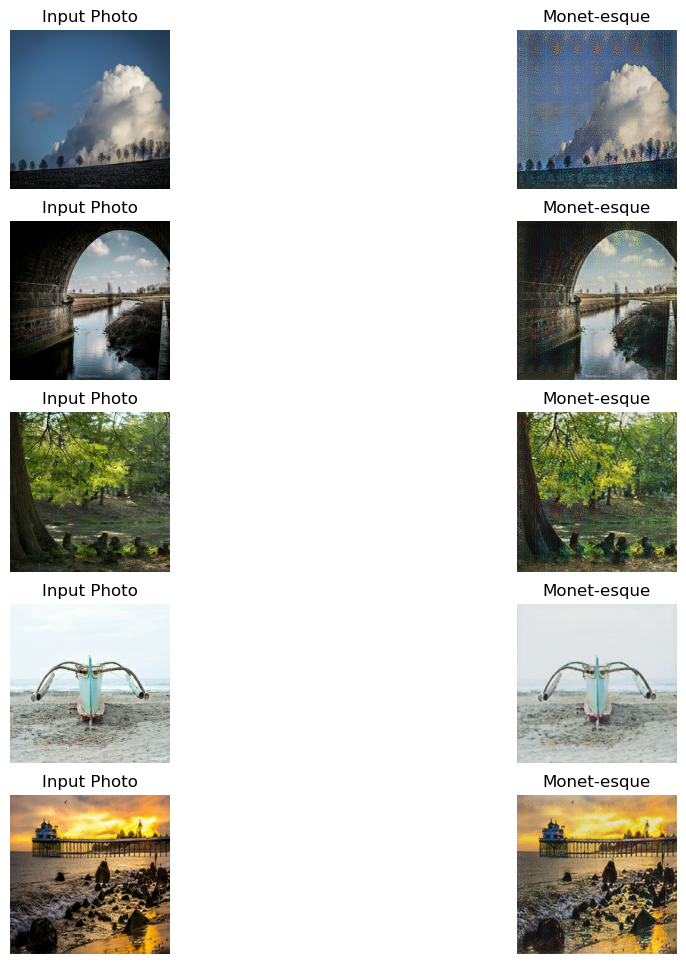

In [27]:
# display several results
_, ax = plt.subplots(5, 2, figsize=(12, 12))
for i, img in enumerate(photo_ds.take(5)):
    prediction = monet_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)
    ax[i, 0].set_title("Input Photo")
    ax[i, 1].set_title("Monet-esque")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
plt.show()

##### 4.2/ Create Submission

We need to generate thousands of new images into a separate to zip it for submission.

In [ ]:
# generate new monet for submission
i = 1
for img in photo_ds:
    prediction = monet_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    im = Image.fromarray(prediction)
    im.save("images/" + str(i) + ".jpg")
    i += 1

### 5/ Conclusion

The CycleGAN is a complicated model requiring a lot of specific tuning to get the best results out of. But the results are quite interesting, as it only take relatively few epochs to reach acceptable results.

In order to get even better results, the following approaches could be made:
* add layers to the generator and discriminators to allows them to learn better the specifics of the data
* add further epochs to refine the accuracy of the model
* preprocess the images differnetly to allow the model to converge faster